# NNDL - CA5

## Import Packages

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import time
import matplotlib.pyplot as plt
from torchvision.models import densenet201
import torch.optim as optim
import time
import numpy as np
from tqdm import tqdm
import timm

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Import Dataset & Preprocessing 

## Transform for Preprocessing 

### Train Data Preprocessing + Augmentation

In [3]:
transform_train = transforms.Compose([
    transforms.Resize((224, 224), antialias= None, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.RandomHorizontalFlip(),  
    transforms.ToTensor(),
    transforms.Normalize((0.49139968, 0.48215827, 0.44653124), (0.24703233, 0.24348505, 0.26158768))
])

### Test Data Preprocessing Without Augmentation

In [4]:
transform_test = transforms.Compose([
    transforms.Resize((224, 224), antialias= None, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize((0.49139968, 0.48215827, 0.44653124), (0.24703233, 0.24348505, 0.26158768))
])

### Import Dataset

In [5]:
train_dataset = CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = CIFAR10(root='./data', train=False, download=True, transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=True, num_workers=2)

100%|██████████| 170498071/170498071 [00:03<00:00, 44288598.78it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


### Check Dataloader

In [6]:
for images, labels in train_loader:
    print(f"Image batch dimensions: {images.size()}")
    print(f"Image label dimensions: {labels.size()}")
    break

Image batch dimensions: torch.Size([512, 3, 224, 224])
Image label dimensions: torch.Size([512])


# Fine-Tuning CNN

## Custom Architecture based on Paper

In [7]:
class CustomModel(nn.Module):
    def __init__(self, base_model):
        super(CustomModel, self).__init__()
        self.base = base_model
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(1920, 256) 
        self.elu = nn.ELU()
        self.dropout = nn.Dropout(0.005)  
        self.linear2 = nn.Linear(256, 10)
        self.softmax = nn.Softmax(dim=1)  # 

    def forward(self, images):
        output = self.base(images)
        output = self.flatten(output) 
        output = self.elu(self.linear1(output))  
        output = self.dropout(output)  
        output = self.linear2(output)  
        output = self.softmax(output) 
        return output

##  Load DenseNet201 model - ImageNet weights

In [8]:
base_cnn_model = densenet201(weights=torchvision.models.DenseNet201_Weights.IMAGENET1K_V1)
base_cnn_model.classifier = torch.nn.Identity()
base_cnn_model.to(device)

Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/hub/checkpoints/densenet201-c1103571.pth
100%|██████████| 77.4M/77.4M [00:00<00:00, 135MB/s] 


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

### Print every Layer

In [9]:
for name, _ in base_cnn_model.named_parameters():  
  print(name)

features.conv0.weight
features.norm0.weight
features.norm0.bias
features.denseblock1.denselayer1.norm1.weight
features.denseblock1.denselayer1.norm1.bias
features.denseblock1.denselayer1.conv1.weight
features.denseblock1.denselayer1.norm2.weight
features.denseblock1.denselayer1.norm2.bias
features.denseblock1.denselayer1.conv2.weight
features.denseblock1.denselayer2.norm1.weight
features.denseblock1.denselayer2.norm1.bias
features.denseblock1.denselayer2.conv1.weight
features.denseblock1.denselayer2.norm2.weight
features.denseblock1.denselayer2.norm2.bias
features.denseblock1.denselayer2.conv2.weight
features.denseblock1.denselayer3.norm1.weight
features.denseblock1.denselayer3.norm1.bias
features.denseblock1.denselayer3.conv1.weight
features.denseblock1.denselayer3.norm2.weight
features.denseblock1.denselayer3.norm2.bias
features.denseblock1.denselayer3.conv2.weight
features.denseblock1.denselayer4.norm1.weight
features.denseblock1.denselayer4.norm1.bias
features.denseblock1.denselaye

### Unfreeze Selected Layers in Paper

In [10]:
for param in base_cnn_model.parameters():
    param.requires_grad = False

for param in base_cnn_model.features.denseblock4.parameters():
    param.requires_grad = True

for param in base_cnn_model.features.norm5.parameters():
    param.requires_grad = True

#for param in base_cnn_model.classifier.parameters():
#    param.requires_grad = True

## Trainable Parameters

In [11]:
cnn_model = CustomModel(base_cnn_model)

In [12]:
trainable_params = sum(p.numel() for p in base_cnn_model.parameters() if p.requires_grad)
print(f"Number of trainable parameters (Base Model): {trainable_params}")

Number of trainable parameters (Base Model): 6982400


In [13]:
trainable_params = sum(p.numel() for p in cnn_model.parameters() if p.requires_grad)
print(f"Number of trainable parameters (Custom Model): {trainable_params}")

Number of trainable parameters (Custom Model): 7476746


## Implement Train Loop

In [14]:
def accuracy(preds, targets):
    return (preds == targets).mean()

def train_model(model, train_loader, val_loader, epochs=20, device='cuda', custom_optimizer=None, custom_loss_fn=None):
    l_rate = 0.0001
    model = model.to(device)
    
    if custom_optimizer is None:
        optimizer = torch.optim.AdamW(model.parameters(), lr=l_rate)
    else:
        optimizer = custom_optimizer
    
    if custom_loss_fn is None:
        loss_fn = nn.CrossEntropyLoss()
    else:
        loss_fn = custom_loss_fn
    
    training_loss_history = []
    validation_loss_history = []
    training_acc_history = []
    validation_acc_history = [0]
    all_validation_targets = []
    all_validation_predicts = []
    epoch_training_times = []
    epoch_validation_times = []

    for epoch in range(epochs):        
        print('Epoch: {}/{}'.format(epoch + 1, epochs))    
        print('Training phase:')
        model.train()
        training_loss = 0 
        targets = []   
        predicts = []
        start_time = time.time()
        for inputs, labels in tqdm(train_loader):
            targets.extend(labels.cpu().numpy())
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            output = model(inputs)
            predicts.extend(output.argmax(dim=1).cpu().numpy())
            loss = loss_fn(output, labels)
            loss.backward()
            optimizer.step()
            training_loss += loss.item()
        end_time = time.time()
        training_time = end_time - start_time
        epoch_training_times.append(training_time)
        
        training_loss /= len(train_loader)
        training_acc = accuracy(np.array(predicts), np.array(targets))
        training_loss_history.append(training_loss)
        training_acc_history.append(training_acc)
        
        print('Validation phase:')
        model.eval()
        validation_loss = 0
        targets = []   
        predicts = []
        start_time = time.time()
        with torch.no_grad():
            for inputs, labels in tqdm(val_loader):        
                targets.extend(labels.cpu().numpy())
                inputs = inputs.to(device)
                labels = labels.to(device)        
                output = model(inputs)
                predicts.extend(output.argmax(dim=1).cpu().numpy())
                loss = loss_fn(output, labels)
                validation_loss += loss.item()
        end_time = time.time()
        validation_time = end_time - start_time
        epoch_validation_times.append(validation_time)
        
        validation_loss /= len(val_loader)
        validation_acc = accuracy(np.array(predicts), np.array(targets))
        validation_loss_history.append(validation_loss)
        validation_acc_history.append(validation_acc)
        
        if validation_acc_history[-1] <= validation_acc_history[-2]:
            if l_rate * 0.6 > 0.0000001:
                l_rate *= 0.6
            else:
                l_rate = 0.0000001
            for g in optimizer.param_groups:          
                g['lr'] = l_rate

        print("Epoch: {}".format(epoch + 1))
        print("      Training loss: {:.3f}        Validation loss: {:.3f}".format(training_loss_history[-1], validation_loss_history[-1]))
        print("  Training accuracy: {:.3f}    Validation accuracy: {:.3f}".format(training_acc_history[-1], validation_acc_history[-1]))
        print("  Training time: {:.3f} seconds    Validation time: {:.3f} seconds".format(training_time, validation_time))

    avg_training_time = sum(epoch_training_times) / epochs
    avg_validation_time = sum(epoch_validation_times) / epochs

    print(f"Average training time per epoch: {avg_training_time:.2f} seconds")
    print(f"Average validation time per epoch: {avg_validation_time:.2f} seconds")

    result = {
        'targets': all_validation_targets,
        'predicts': all_validation_predicts,
        'training_loss': training_loss_history,
        'validation_loss': validation_loss_history,
        'training_accuracy': training_acc_history,
        'validation_accuracy': validation_acc_history,
        'epoch_training_times': epoch_training_times,
        'epoch_validation_times': epoch_validation_times,
    }
    return result


## FineTune Model

In [15]:
num_epochs = 20
results = train_model(cnn_model, train_loader, test_loader, epochs=num_epochs, device=device)

Epoch: 1/20
Training phase:


100%|██████████| 98/98 [02:54<00:00,  1.78s/it]


Validation phase:


100%|██████████| 20/20 [00:27<00:00,  1.37s/it]


Epoch: 1
      Training loss: 1.793        Validation loss: 1.585
  Training accuracy: 0.734    Validation accuracy: 0.889
  Training time: 174.106 seconds    Validation time: 27.358 seconds
Epoch: 2/20
Training phase:


100%|██████████| 98/98 [02:52<00:00,  1.76s/it]


Validation phase:


100%|██████████| 20/20 [00:27<00:00,  1.36s/it]


Epoch: 2
      Training loss: 1.561        Validation loss: 1.561
  Training accuracy: 0.907    Validation accuracy: 0.906
  Training time: 172.819 seconds    Validation time: 27.281 seconds
Epoch: 3/20
Training phase:


100%|██████████| 98/98 [02:53<00:00,  1.77s/it]


Validation phase:


100%|██████████| 20/20 [00:27<00:00,  1.36s/it]


Epoch: 3
      Training loss: 1.536        Validation loss: 1.556
  Training accuracy: 0.929    Validation accuracy: 0.908
  Training time: 173.064 seconds    Validation time: 27.316 seconds
Epoch: 4/20
Training phase:


100%|██████████| 98/98 [02:53<00:00,  1.77s/it]


Validation phase:


100%|██████████| 20/20 [00:27<00:00,  1.36s/it]


Epoch: 4
      Training loss: 1.521        Validation loss: 1.549
  Training accuracy: 0.944    Validation accuracy: 0.915
  Training time: 173.231 seconds    Validation time: 27.262 seconds
Epoch: 5/20
Training phase:


100%|██████████| 98/98 [02:53<00:00,  1.77s/it]


Validation phase:


100%|██████████| 20/20 [00:27<00:00,  1.37s/it]


Epoch: 5
      Training loss: 1.510        Validation loss: 1.547
  Training accuracy: 0.954    Validation accuracy: 0.917
  Training time: 173.282 seconds    Validation time: 27.478 seconds
Epoch: 6/20
Training phase:


100%|██████████| 98/98 [02:53<00:00,  1.77s/it]


Validation phase:


100%|██████████| 20/20 [00:27<00:00,  1.37s/it]


Epoch: 6
      Training loss: 1.502        Validation loss: 1.542
  Training accuracy: 0.961    Validation accuracy: 0.921
  Training time: 173.366 seconds    Validation time: 27.463 seconds
Epoch: 7/20
Training phase:


100%|██████████| 98/98 [02:53<00:00,  1.77s/it]


Validation phase:


100%|██████████| 20/20 [00:27<00:00,  1.38s/it]


Epoch: 7
      Training loss: 1.497        Validation loss: 1.545
  Training accuracy: 0.966    Validation accuracy: 0.919
  Training time: 173.165 seconds    Validation time: 27.541 seconds
Epoch: 8/20
Training phase:


100%|██████████| 98/98 [02:53<00:00,  1.77s/it]


Validation phase:


100%|██████████| 20/20 [00:27<00:00,  1.37s/it]


Epoch: 8
      Training loss: 1.490        Validation loss: 1.538
  Training accuracy: 0.973    Validation accuracy: 0.922
  Training time: 173.404 seconds    Validation time: 27.376 seconds
Epoch: 9/20
Training phase:


100%|██████████| 98/98 [02:53<00:00,  1.77s/it]


Validation phase:


100%|██████████| 20/20 [00:27<00:00,  1.37s/it]


Epoch: 9
      Training loss: 1.486        Validation loss: 1.538
  Training accuracy: 0.977    Validation accuracy: 0.925
  Training time: 173.195 seconds    Validation time: 27.407 seconds
Epoch: 10/20
Training phase:


100%|██████████| 98/98 [02:53<00:00,  1.77s/it]


Validation phase:


100%|██████████| 20/20 [00:27<00:00,  1.37s/it]


Epoch: 10
      Training loss: 1.484        Validation loss: 1.538
  Training accuracy: 0.979    Validation accuracy: 0.925
  Training time: 173.090 seconds    Validation time: 27.397 seconds
Epoch: 11/20
Training phase:


100%|██████████| 98/98 [02:53<00:00,  1.77s/it]


Validation phase:


100%|██████████| 20/20 [00:27<00:00,  1.37s/it]


Epoch: 11
      Training loss: 1.481        Validation loss: 1.537
  Training accuracy: 0.981    Validation accuracy: 0.925
  Training time: 173.162 seconds    Validation time: 27.391 seconds
Epoch: 12/20
Training phase:


100%|██████████| 98/98 [02:53<00:00,  1.77s/it]


Validation phase:


100%|██████████| 20/20 [00:27<00:00,  1.37s/it]


Epoch: 12
      Training loss: 1.480        Validation loss: 1.537
  Training accuracy: 0.982    Validation accuracy: 0.925
  Training time: 173.342 seconds    Validation time: 27.344 seconds
Epoch: 13/20
Training phase:


100%|██████████| 98/98 [02:52<00:00,  1.77s/it]


Validation phase:


100%|██████████| 20/20 [00:27<00:00,  1.36s/it]


Epoch: 13
      Training loss: 1.479        Validation loss: 1.534
  Training accuracy: 0.983    Validation accuracy: 0.929
  Training time: 173.022 seconds    Validation time: 27.241 seconds
Epoch: 14/20
Training phase:


100%|██████████| 98/98 [02:53<00:00,  1.77s/it]


Validation phase:


100%|██████████| 20/20 [00:27<00:00,  1.36s/it]


Epoch: 14
      Training loss: 1.478        Validation loss: 1.535
  Training accuracy: 0.984    Validation accuracy: 0.927
  Training time: 173.087 seconds    Validation time: 27.293 seconds
Epoch: 15/20
Training phase:


100%|██████████| 98/98 [02:53<00:00,  1.77s/it]


Validation phase:


100%|██████████| 20/20 [00:27<00:00,  1.37s/it]


Epoch: 15
      Training loss: 1.477        Validation loss: 1.534
  Training accuracy: 0.984    Validation accuracy: 0.929
  Training time: 173.061 seconds    Validation time: 27.397 seconds
Epoch: 16/20
Training phase:


100%|██████████| 98/98 [02:53<00:00,  1.77s/it]


Validation phase:


100%|██████████| 20/20 [00:27<00:00,  1.37s/it]


Epoch: 16
      Training loss: 1.477        Validation loss: 1.535
  Training accuracy: 0.985    Validation accuracy: 0.928
  Training time: 173.054 seconds    Validation time: 27.394 seconds
Epoch: 17/20
Training phase:


100%|██████████| 98/98 [02:53<00:00,  1.77s/it]


Validation phase:


100%|██████████| 20/20 [00:27<00:00,  1.37s/it]


Epoch: 17
      Training loss: 1.476        Validation loss: 1.533
  Training accuracy: 0.985    Validation accuracy: 0.930
  Training time: 173.066 seconds    Validation time: 27.400 seconds
Epoch: 18/20
Training phase:


100%|██████████| 98/98 [02:53<00:00,  1.77s/it]


Validation phase:


100%|██████████| 20/20 [00:27<00:00,  1.37s/it]


Epoch: 18
      Training loss: 1.476        Validation loss: 1.533
  Training accuracy: 0.986    Validation accuracy: 0.930
  Training time: 173.144 seconds    Validation time: 27.413 seconds
Epoch: 19/20
Training phase:


100%|██████████| 98/98 [02:53<00:00,  1.77s/it]


Validation phase:


100%|██████████| 20/20 [00:27<00:00,  1.37s/it]


Epoch: 19
      Training loss: 1.476        Validation loss: 1.533
  Training accuracy: 0.986    Validation accuracy: 0.930
  Training time: 173.093 seconds    Validation time: 27.335 seconds
Epoch: 20/20
Training phase:


100%|██████████| 98/98 [02:52<00:00,  1.77s/it]


Validation phase:


100%|██████████| 20/20 [00:27<00:00,  1.37s/it]

Epoch: 20
      Training loss: 1.476        Validation loss: 1.533
  Training accuracy: 0.986    Validation accuracy: 0.930
  Training time: 173.037 seconds    Validation time: 27.349 seconds
Average training time per epoch: 173.19 seconds
Average validation time per epoch: 27.37 seconds


## Plot the Loss and Accuracy

### Loss

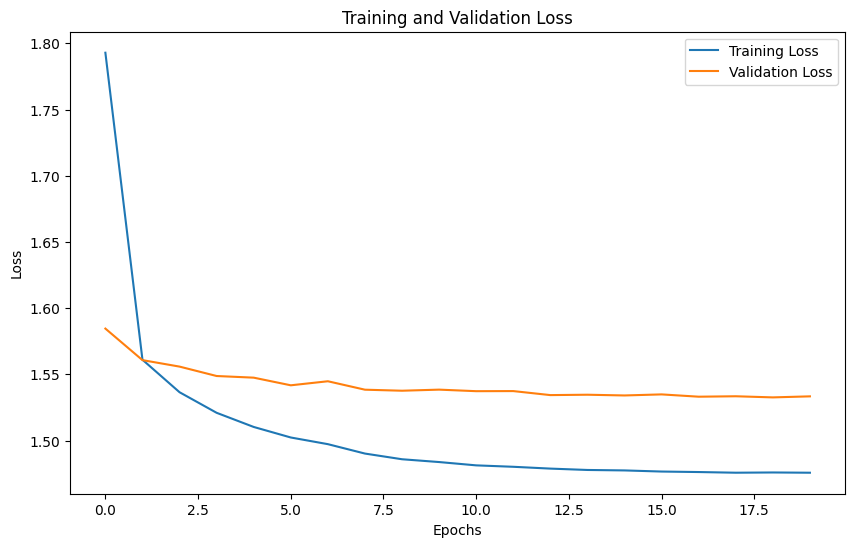

In [22]:
plt.figure(figsize=(10, 6))
plt.plot(results['training_loss'], label='Training Loss')
plt.plot(results['validation_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

### Accuracy

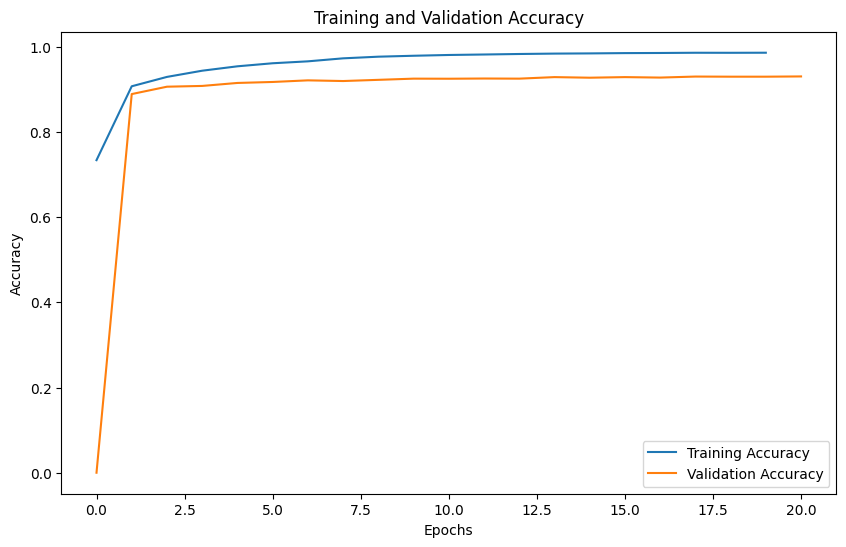

In [23]:
plt.figure(figsize=(10, 6))
plt.plot(results['training_accuracy'], label='Training Accuracy')
plt.plot(results['validation_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

## Training and Validation Times

In [24]:
final_training_accuracy = results['training_accuracy'][-1]
final_validation_accuracy = results['validation_accuracy'][-1]

avg_training_time = sum(results['epoch_training_times']) / num_epochs
avg_validation_time = sum(results['epoch_validation_times']) / num_epochs

print(f"Final Training Accuracy: {final_training_accuracy:.4f}")
print(f"Final Validation Accuracy: {final_validation_accuracy:.4f}")

print(f"Average Training Time per Epoch: {avg_training_time:.2f} seconds")
print(f"Average Validation Time per Epoch: {avg_validation_time:.2f} seconds")

Final Training Accuracy: 0.9860
Final Validation Accuracy: 0.9303
Average Training Time per Epoch: 173.19 seconds
Average Validation Time per Epoch: 27.37 seconds


# Fine-Tuning Transformer Model

## Load CaiTS24 model from timm

In [15]:
model_name = "cait_s24_224"
base_transformer_model = timm.create_model(model_name, pretrained=True, num_classes=0)

model.safetensors:   0%|          | 0.00/188M [00:00<?, ?B/s]

In [16]:
base_transformer_model

Cait(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): Sequential(
    (0): LayerScaleBlock(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): TalkingHeadAttn(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_l): Linear(in_features=8, out_features=8, bias=True)
        (proj_w): Linear(in_features=8, out_features=8, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identit

### Print every Layer

In [17]:
for name, _ in base_transformer_model.named_parameters():
  print(name)

cls_token
pos_embed
patch_embed.proj.weight
patch_embed.proj.bias
blocks.0.gamma_1
blocks.0.gamma_2
blocks.0.norm1.weight
blocks.0.norm1.bias
blocks.0.attn.qkv.weight
blocks.0.attn.qkv.bias
blocks.0.attn.proj.weight
blocks.0.attn.proj.bias
blocks.0.attn.proj_l.weight
blocks.0.attn.proj_l.bias
blocks.0.attn.proj_w.weight
blocks.0.attn.proj_w.bias
blocks.0.norm2.weight
blocks.0.norm2.bias
blocks.0.mlp.fc1.weight
blocks.0.mlp.fc1.bias
blocks.0.mlp.fc2.weight
blocks.0.mlp.fc2.bias
blocks.1.gamma_1
blocks.1.gamma_2
blocks.1.norm1.weight
blocks.1.norm1.bias
blocks.1.attn.qkv.weight
blocks.1.attn.qkv.bias
blocks.1.attn.proj.weight
blocks.1.attn.proj.bias
blocks.1.attn.proj_l.weight
blocks.1.attn.proj_l.bias
blocks.1.attn.proj_w.weight
blocks.1.attn.proj_w.bias
blocks.1.norm2.weight
blocks.1.norm2.bias
blocks.1.mlp.fc1.weight
blocks.1.mlp.fc1.bias
blocks.1.mlp.fc2.weight
blocks.1.mlp.fc2.bias
blocks.2.gamma_1
blocks.2.gamma_2
blocks.2.norm1.weight
blocks.2.norm1.bias
blocks.2.attn.qkv.weight
b

## Unfreeze Layers


In [18]:
for param in base_transformer_model.parameters():
    param.requires_grad = False

for param in base_transformer_model.blocks_token_only[1].parameters():
    param.requires_grad = True

for param in base_transformer_model.norm.parameters():
    param.requires_grad = True

### CustomModel For Transformer

In [19]:
class CustomModel(nn.Module):
    def __init__(self, base_model):
        super(CustomModel, self).__init__()
        self.base = base_model
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(384, 256) 
        self.elu = nn.ELU()
        self.dropout = nn.Dropout(0.005)  
        self.linear2 = nn.Linear(256, 10)
        self.softmax = nn.Softmax(dim=1)  # 

    def forward(self, images):
        output = self.base(images)
        output = self.flatten(output) 
        output = self.elu(self.linear1(output))  
        output = self.dropout(output)  
        output = self.linear2(output)  
        output = self.softmax(output) 
        return output

In [20]:
transformer_model = CustomModel(base_transformer_model)

## Trainable Parameters


In [21]:
trainable_params = sum(p.numel() for p in base_transformer_model.parameters() if p.requires_grad)
print(f"Number of trainable parameters (Base Model): {trainable_params}")

Number of trainable parameters (Base Model): 1776000


In [22]:
trainable_params = sum(p.numel() for p in transformer_model.parameters() if p.requires_grad)
print(f"Number of trainable parameters (Custom Model): {trainable_params}")

Number of trainable parameters (Custom Model): 1877130


In [23]:
num_epochs = 20
results_transformer = train_model(transformer_model, train_loader, test_loader, epochs=num_epochs, device=device)

Epoch: 1/20
Training phase:


100%|██████████| 98/98 [05:09<00:00,  3.15s/it]


Validation phase:


100%|██████████| 20/20 [01:01<00:00,  3.10s/it]


Epoch: 1
      Training loss: 1.703        Validation loss: 1.532
  Training accuracy: 0.861    Validation accuracy: 0.943
  Training time: 309.151 seconds    Validation time: 62.028 seconds
Epoch: 2/20
Training phase:


100%|██████████| 98/98 [05:08<00:00,  3.14s/it]


Validation phase:


100%|██████████| 20/20 [01:01<00:00,  3.10s/it]


Epoch: 2
      Training loss: 1.519        Validation loss: 1.516
  Training accuracy: 0.951    Validation accuracy: 0.952
  Training time: 308.190 seconds    Validation time: 62.004 seconds
Epoch: 3/20
Training phase:


100%|██████████| 98/98 [05:08<00:00,  3.14s/it]


Validation phase:


100%|██████████| 20/20 [01:02<00:00,  3.10s/it]


Epoch: 3
      Training loss: 1.506        Validation loss: 1.509
  Training accuracy: 0.960    Validation accuracy: 0.955
  Training time: 308.085 seconds    Validation time: 62.054 seconds
Epoch: 4/20
Training phase:


100%|██████████| 98/98 [05:08<00:00,  3.15s/it]


Validation phase:


100%|██████████| 20/20 [01:01<00:00,  3.10s/it]


Epoch: 4
      Training loss: 1.500        Validation loss: 1.507
  Training accuracy: 0.965    Validation accuracy: 0.956
  Training time: 308.404 seconds    Validation time: 62.018 seconds
Epoch: 5/20
Training phase:


100%|██████████| 98/98 [05:08<00:00,  3.15s/it]


Validation phase:


100%|██████████| 20/20 [01:02<00:00,  3.10s/it]


Epoch: 5
      Training loss: 1.494        Validation loss: 1.504
  Training accuracy: 0.970    Validation accuracy: 0.959
  Training time: 308.281 seconds    Validation time: 62.054 seconds
Epoch: 6/20
Training phase:


100%|██████████| 98/98 [05:08<00:00,  3.15s/it]


Validation phase:


100%|██████████| 20/20 [01:02<00:00,  3.10s/it]


Epoch: 6
      Training loss: 1.490        Validation loss: 1.504
  Training accuracy: 0.974    Validation accuracy: 0.959
  Training time: 308.272 seconds    Validation time: 62.112 seconds
Epoch: 7/20
Training phase:


100%|██████████| 98/98 [05:08<00:00,  3.15s/it]


Validation phase:


100%|██████████| 20/20 [01:02<00:00,  3.10s/it]


Epoch: 7
      Training loss: 1.487        Validation loss: 1.503
  Training accuracy: 0.977    Validation accuracy: 0.958
  Training time: 308.439 seconds    Validation time: 62.083 seconds
Epoch: 8/20
Training phase:


100%|██████████| 98/98 [05:08<00:00,  3.15s/it]


Validation phase:


100%|██████████| 20/20 [01:02<00:00,  3.10s/it]


Epoch: 8
      Training loss: 1.483        Validation loss: 1.501
  Training accuracy: 0.979    Validation accuracy: 0.960
  Training time: 308.276 seconds    Validation time: 62.084 seconds
Epoch: 9/20
Training phase:


100%|██████████| 98/98 [05:08<00:00,  3.15s/it]


Validation phase:


100%|██████████| 20/20 [01:02<00:00,  3.10s/it]


Epoch: 9
      Training loss: 1.481        Validation loss: 1.501
  Training accuracy: 0.982    Validation accuracy: 0.961
  Training time: 308.439 seconds    Validation time: 62.129 seconds
Epoch: 10/20
Training phase:


100%|██████████| 98/98 [05:08<00:00,  3.15s/it]


Validation phase:


100%|██████████| 20/20 [01:02<00:00,  3.11s/it]


Epoch: 10
      Training loss: 1.480        Validation loss: 1.501
  Training accuracy: 0.983    Validation accuracy: 0.961
  Training time: 308.464 seconds    Validation time: 62.143 seconds
Epoch: 11/20
Training phase:


100%|██████████| 98/98 [05:08<00:00,  3.14s/it]


Validation phase:


100%|██████████| 20/20 [01:02<00:00,  3.10s/it]


Epoch: 11
      Training loss: 1.478        Validation loss: 1.500
  Training accuracy: 0.984    Validation accuracy: 0.962
  Training time: 308.185 seconds    Validation time: 62.097 seconds
Epoch: 12/20
Training phase:


100%|██████████| 98/98 [05:08<00:00,  3.15s/it]


Validation phase:


100%|██████████| 20/20 [01:02<00:00,  3.10s/it]


Epoch: 12
      Training loss: 1.478        Validation loss: 1.501
  Training accuracy: 0.985    Validation accuracy: 0.961
  Training time: 308.416 seconds    Validation time: 62.070 seconds
Epoch: 13/20
Training phase:


100%|██████████| 98/98 [05:08<00:00,  3.15s/it]


Validation phase:


100%|██████████| 20/20 [01:01<00:00,  3.10s/it]


Epoch: 13
      Training loss: 1.477        Validation loss: 1.500
  Training accuracy: 0.985    Validation accuracy: 0.962
  Training time: 308.253 seconds    Validation time: 62.030 seconds
Epoch: 14/20
Training phase:


100%|██████████| 98/98 [05:08<00:00,  3.15s/it]


Validation phase:


100%|██████████| 20/20 [01:02<00:00,  3.10s/it]


Epoch: 14
      Training loss: 1.477        Validation loss: 1.500
  Training accuracy: 0.986    Validation accuracy: 0.962
  Training time: 308.370 seconds    Validation time: 62.069 seconds
Epoch: 15/20
Training phase:


100%|██████████| 98/98 [05:08<00:00,  3.15s/it]


Validation phase:


100%|██████████| 20/20 [01:02<00:00,  3.10s/it]


Epoch: 15
      Training loss: 1.476        Validation loss: 1.501
  Training accuracy: 0.986    Validation accuracy: 0.962
  Training time: 308.356 seconds    Validation time: 62.078 seconds
Epoch: 16/20
Training phase:


100%|██████████| 98/98 [05:08<00:00,  3.14s/it]


Validation phase:


100%|██████████| 20/20 [01:02<00:00,  3.10s/it]


Epoch: 16
      Training loss: 1.476        Validation loss: 1.500
  Training accuracy: 0.986    Validation accuracy: 0.962
  Training time: 308.213 seconds    Validation time: 62.041 seconds
Epoch: 17/20
Training phase:


100%|██████████| 98/98 [05:08<00:00,  3.15s/it]


Validation phase:


100%|██████████| 20/20 [01:02<00:00,  3.10s/it]


Epoch: 17
      Training loss: 1.476        Validation loss: 1.500
  Training accuracy: 0.987    Validation accuracy: 0.962
  Training time: 308.338 seconds    Validation time: 62.048 seconds
Epoch: 18/20
Training phase:


100%|██████████| 98/98 [05:08<00:00,  3.14s/it]


Validation phase:


100%|██████████| 20/20 [01:02<00:00,  3.10s/it]


Epoch: 18
      Training loss: 1.475        Validation loss: 1.500
  Training accuracy: 0.987    Validation accuracy: 0.963
  Training time: 308.236 seconds    Validation time: 62.062 seconds
Epoch: 19/20
Training phase:


100%|██████████| 98/98 [05:08<00:00,  3.14s/it]


Validation phase:


100%|██████████| 20/20 [01:02<00:00,  3.10s/it]


Epoch: 19
      Training loss: 1.475        Validation loss: 1.499
  Training accuracy: 0.987    Validation accuracy: 0.962
  Training time: 308.194 seconds    Validation time: 62.074 seconds
Epoch: 20/20
Training phase:


100%|██████████| 98/98 [05:08<00:00,  3.15s/it]


Validation phase:


100%|██████████| 20/20 [01:02<00:00,  3.10s/it]

Epoch: 20
      Training loss: 1.475        Validation loss: 1.500
  Training accuracy: 0.987    Validation accuracy: 0.962
  Training time: 308.281 seconds    Validation time: 62.050 seconds
Average training time per epoch: 308.34 seconds
Average validation time per epoch: 62.07 seconds


## Plot the Loss and Accuracy

### Loss

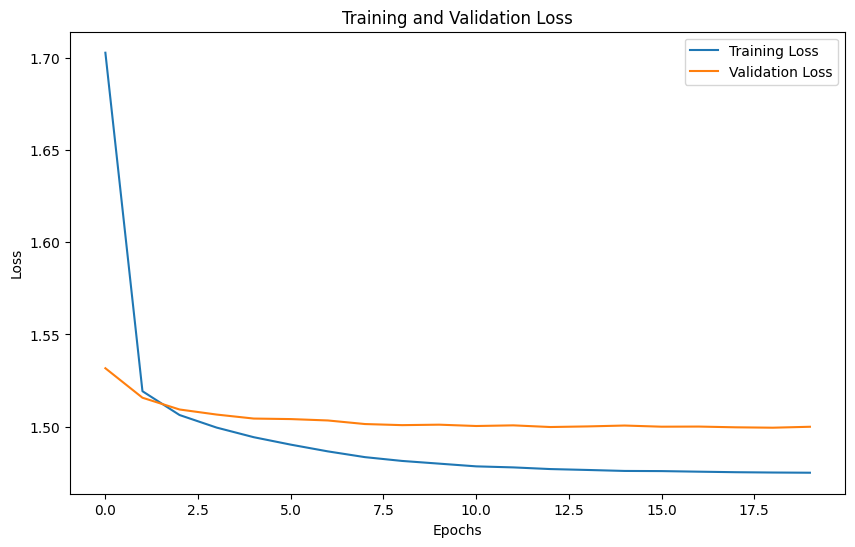

In [24]:
plt.figure(figsize=(10, 6))
plt.plot(results_transformer['training_loss'], label='Training Loss')
plt.plot(results_transformer['validation_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

### Accuracy

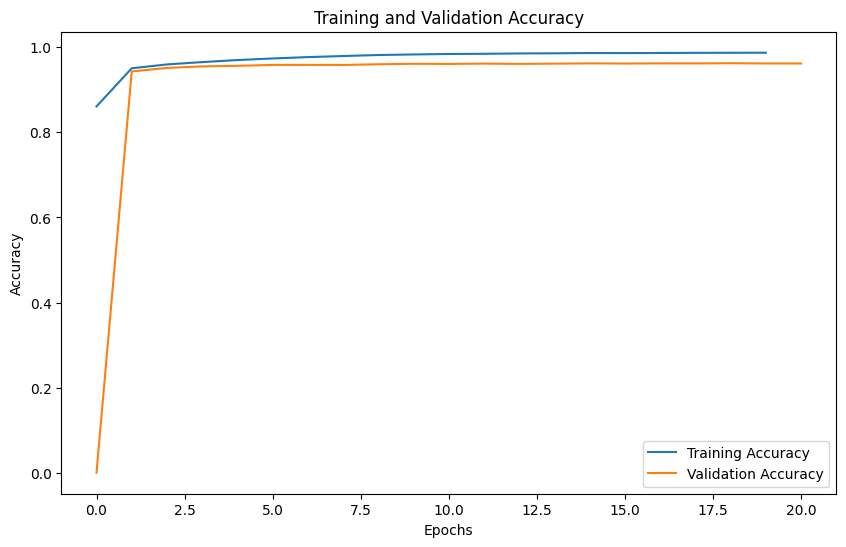

In [25]:
plt.figure(figsize=(10, 6))
plt.plot(results_transformer['training_accuracy'], label='Training Accuracy')
plt.plot(results_transformer['validation_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

## Training and Validation Times

In [26]:
final_training_accuracy = results_transformer['training_accuracy'][-1]
final_validation_accuracy = results_transformer['validation_accuracy'][-1]

avg_training_time = sum(results_transformer['epoch_training_times']) / num_epochs
avg_validation_time = sum(results_transformer['epoch_validation_times']) / num_epochs

print(f"Final Training Accuracy: {final_training_accuracy:.4f}")
print(f"Final Validation Accuracy: {final_validation_accuracy:.4f}")

print(f"Average Training Time per Epoch: {avg_training_time:.2f} seconds")
print(f"Average Validation Time per Epoch: {avg_validation_time:.2f} seconds")

Final Training Accuracy: 0.9872
Final Validation Accuracy: 0.9619
Average Training Time per Epoch: 308.34 seconds
Average Validation Time per Epoch: 62.07 seconds
